In [1]:
import importlib
import utils.data_loader
import utils.tokenize
import models.embedding
import models.nn
import models.scaled_dot_product_attention

#For reloading
importlib.reload(utils.data_loader)
importlib.reload(utils.tokenize)
importlib.reload(models.embedding)
importlib.reload(models.nn)
importlib.reload(models.scaled_dot_product_attention)

Initialized from jupyter or other except terminal or command prompt script!


<module 'models.scaled_dot_product_attention' from '/Users/bimalmgr/Downloads/deep_learning/transformers/trnsfmr_from_scratch/models/scaled_dot_product_attention.py'>

In [2]:
from utils.data_loader import DataLoader
from utils.tokenize import Tokenizer
from data import en,es
from models.embedding import Embeddings
from data import en,es
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def reload_modules():
    %load_ext autoreload
    %autoreload 2

In [4]:
reload_modules()
print("This is the implementation of transformer from scratch in PyTorch.........!!")
tokenizer = Tokenizer()
data_loader = DataLoader(
    tokenize_source=tokenizer.tokenize_source,
    tokenize_target=tokenizer.tokenize_target
)
train_set,valid_set,test_set = data_loader.make_dataset(es,en)
vocab_src,vocab_trg = data_loader.build_vocab(train_set,valid_set,test_set)
print(len(vocab_src))
for word,index in vocab_trg.get_stoi().items():
    if index < 10:
        print(word,index)
for w,i in vocab_src.get_stoi().items():
    if i < 10:
        print(w,i)
# print(f"Tokenized source example: {tokenizer.tokenize_source('Mi nombre es Bimal !! @ 1 23 * ;.')}")
# print(f"Tokenized target example: {tokenizer.tokenize_target('My name is Bimal !! @ 1 23 * ;.')}")
# print(f"Dataset examples: {data_loader.make_dataset(['Mi nombre es Bimal !! @ 1 23 * ;.'],['My name is Bimal !! @ 1 23 * ;.'])}")
# s_tr,s_v,s_te = data_loader.make_dataset(['Mi nombre ','es Bimal !!','@ 1 23 * ;.'],['My name','is Bimal !!','@ 1 23 * ;.'])
# print("train",s_tr,"val",s_v,"test",s_te)
# s_v,s_t = data_loader.build_vocab(s_tr,s_v,s_te)
# print(s_v.get_stoi())
# print(s_t.get_stoi())
# print("Source vobularies:",vocab_src)
embed = nn.Embedding(len(vocab_src),5)
embed_target = nn.Embedding(len(vocab_trg),5)
# print(embed(torch.tensor([s_v.get_stoi()['Bimal'],s_v.get_stoi()['nombre']])))
# print(embed(torch.tensor(vocab_src.get_stoi()['víctimas'])))
# for tr in train_set[0:2]:
#     source_data = torch.tensor(vocab_src(tr["src"]))
#     target_data = torch.tensor(vocab_trg(tr["trg"]))
#     print(f"{embed(source_data)}\n")
#     print(f"{embed(target_data)}\n")
# print(embed(torch.tensor(vocab_src(train_set[0]["src"]))))
# print(embed(torch.tensor(vocab_trg(train_set[0]["trg"]))))
# print(len(train_set[0]["src"]))
# print(len(train_set[0]["trg"]))

# print(train_set)

This is the implementation of transformer from scratch in PyTorch.........!!
Initializing the data loader........
Building vocabularies...
Source vocabulary size: 385
Target vocabulary size: 368
385
, 4
. 7
the 5
to 9
<eos> 3
<pad> 1
a 8
<sos> 2
of 6
<unk> 0
, 5
. 7
<unk> 0
la 9
<eos> 3
<sos> 2
de 4
el 8
que 6
<pad> 1


In [5]:
train_iter,valid_iter,test_iter = data_loader.create_iterators(
    train_set,
    valid_set,
    test_set,
    vocab_src,
    vocab_trg,
    batch_size=4,
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
)

In [6]:
src_batch,_ = next(iter(train_iter))
src_embed = embed(src_batch)
print(src_embed.shape)
print(src_embed)

torch.Size([4, 48, 5])
tensor([[[ 1.0896e+00, -3.7724e-01,  9.4755e-01, -1.0983e+00,  4.9364e-03],
         [ 1.1519e+00,  2.5122e-01,  9.3257e-01,  8.9603e-01,  1.0766e+00],
         [-5.1391e-01, -4.4337e-01, -1.9850e-01, -1.8584e+00,  1.2803e+00],
         [-9.6309e-01,  1.9361e+00,  3.9543e-01,  5.4870e-01, -1.6810e-01],
         [ 2.7624e+00,  1.9075e+00,  1.9516e+00, -7.5560e-01, -9.9402e-01],
         [ 1.5956e+00,  9.9430e-01,  1.5186e-01,  1.5000e-01, -5.7863e-01],
         [ 8.8110e-01, -6.4410e-01, -3.2884e-02,  1.2132e+00, -1.0125e+00],
         [-1.5393e+00,  5.9585e-01,  1.5410e+00, -8.1504e-01, -1.1445e+00],
         [ 1.5671e+00, -6.5552e-01, -2.6186e-01, -1.9668e+00, -1.9801e-01],
         [-9.6309e-01,  1.9361e+00,  3.9543e-01,  5.4870e-01, -1.6810e-01],
         [ 2.7624e+00,  1.9075e+00,  1.9516e+00, -7.5560e-01, -9.9402e-01],
         [ 1.5956e+00,  9.9430e-01,  1.5186e-01,  1.5000e-01, -5.7863e-01],
         [-5.1391e-01, -4.4337e-01, -1.9850e-01, -1.8584e+00,  1.

In [11]:
def visualise_attention_scores(scores,words,vocab_type):
    scores_np = scores.detach().numpy()
    plt.figure(figsize=(18,8))
    sns.heatmap(scores_np,xticklabels=words,yticklabels=words,annot=True,fmt='.1f',cmap="Blues")
    plt.title(f"Attention scores visualization for Query and Key of first sentence of {vocab_type}")
    plt.xlabel("Keys")
    plt.ylabel("Query")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [28]:
from models.scaled_dot_product_attention import ScaledDotProductAttention
print(f"The attention scores of of the first sentence in our dataset\n")
first_sentence_src = train_set[0]["src"]
first_sen_embed_src = embed(torch.tensor(vocab_src(first_sentence_src)))
print(f"Query, Key and Value shape: {first_sen_embed_src.shape}")
scaled_attn = ScaledDotProductAttention(6)

The attention scores of of the first sentence in our dataset

Query, Key and Value shape: torch.Size([40, 5])


46
<sos> => 2
Resumption => 141
of => 6
the => 5
session => 31
I => 13
declare => 197
resumed => 312
the => 5
session => 31
of => 6
the => 5
European => 24
Parliament => 19
adjourned => 157
on => 15
Friday => 124
17 => 110
December => 122
1999 => 111
, => 4
and => 10
I => 13
would => 33
like => 38
once => 94
again => 73
to => 9
wish => 105
you => 16
a => 8
happy => 227
new => 266
year => 43
in => 11
the => 5
hope => 231
that => 12
you => 16
enjoyed => 205
a => 8
pleasant => 283
festive => 214
period => 280
. => 7
<eos> => 3


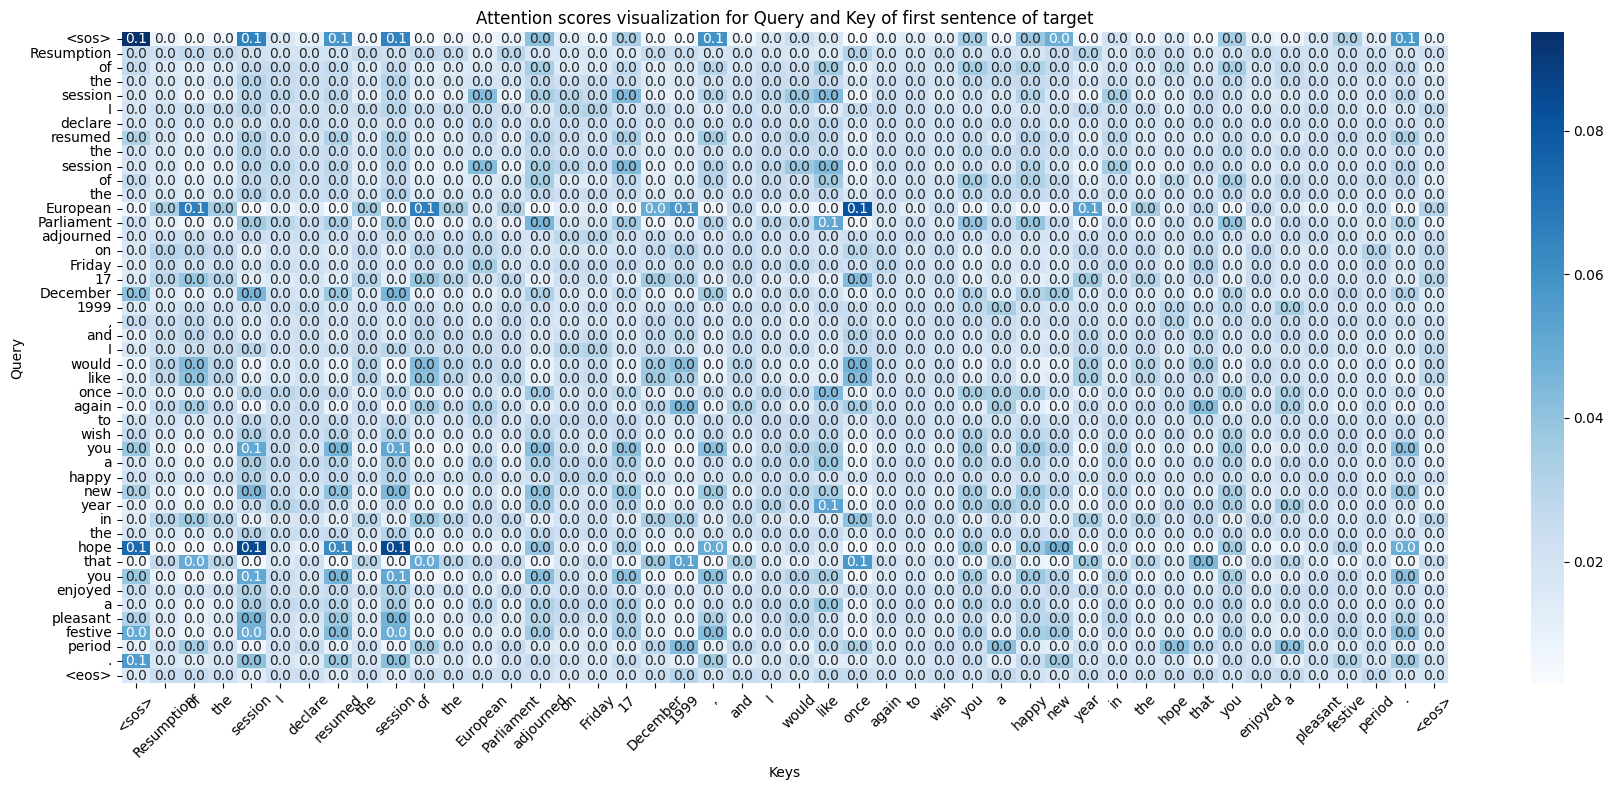

In [32]:
# Scaled dot product attention for the first sentence.
first_sentence = train_set[0]['trg']
first_sentence_indices = [vocab_trg[token] for token in first_sentence]
print(len(first_sentence_indices))
for word,index in zip(first_sentence,first_sentence_indices):
    print(word,"=>",index)
# Make embeddings of first sentence:
first_sen_embed = nn.Embedding(len(vocab_trg),embedding_dim=6)
first_sen_embedded = first_sen_embed(torch.tensor([first_sentence_indices]))
first_sen_embedded
# print("After passing to the forward layer ==> ",first_sen_embedded)
score,op = scaled_attn.query_key_value_attention(first_sen_embedded,first_sen_embedded,first_sen_embedded)
# print(torch.tensor()
visualise_attention_scores(score.squeeze(0),first_sentence,"target")

In [39]:
#Demo tensor with  shape (1,5,6) => (batch_size,seq_length,d_model)
demo_tensor = torch.tensor([[[0.1484, 0.1391, 0.8219, 0.4047, 0.9686, 0.9375],
         [0.8506, 0.5759, 0.2389, 0.8429, 0.2111, 0.7278],
         [0.6436, 0.4133, 0.6907, 0.9291, 0.1288, 0.0928],
         [0.2481, 0.1174, 0.4663, 0.7672, 0.6386, 0.3119],
         [0.4140, 0.0791, 0.2099, 0.5602, 0.3188, 0.2513]]])
demo_tensor
print("Without transposing into 2 heads",demo_tensor.view(1,5,2,3))
print("After transposing into 2 heads",demo_tensor.view(1,5,2,3).transpose(1,2))

print("After directly transposing into 2 heads",demo_tensor.view(1,2,5,3))

Without transposing into 2 heads tensor([[[[0.1484, 0.1391, 0.8219],
          [0.4047, 0.9686, 0.9375]],

         [[0.8506, 0.5759, 0.2389],
          [0.8429, 0.2111, 0.7278]],

         [[0.6436, 0.4133, 0.6907],
          [0.9291, 0.1288, 0.0928]],

         [[0.2481, 0.1174, 0.4663],
          [0.7672, 0.6386, 0.3119]],

         [[0.4140, 0.0791, 0.2099],
          [0.5602, 0.3188, 0.2513]]]])
After transposing into 2 heads tensor([[[[0.1484, 0.1391, 0.8219],
          [0.8506, 0.5759, 0.2389],
          [0.6436, 0.4133, 0.6907],
          [0.2481, 0.1174, 0.4663],
          [0.4140, 0.0791, 0.2099]],

         [[0.4047, 0.9686, 0.9375],
          [0.8429, 0.2111, 0.7278],
          [0.9291, 0.1288, 0.0928],
          [0.7672, 0.6386, 0.3119],
          [0.5602, 0.3188, 0.2513]]]])
After directly transposing into 2 heads tensor([[[[0.1484, 0.1391, 0.8219],
          [0.4047, 0.9686, 0.9375],
          [0.8506, 0.5759, 0.2389],
          [0.8429, 0.2111, 0.7278],
          [0.643

In [20]:
m =  nn.Linear(5,5)
input = torch.randn(2,5)
print(f"Input: {input};\n Weights: {m.weight} \n Bias:{m.bias} \n After transformation: {m(input)}\n")

Input: tensor([[-1.4970, -0.1966, -1.4078, -1.8236,  1.0361],
        [-0.3978, -0.6541,  0.3981, -0.2730, -0.1556]]);
 Weights: Parameter containing:
tensor([[ 0.0343,  0.2790,  0.1157, -0.0241,  0.1515],
        [-0.4164, -0.2430,  0.0365, -0.4176, -0.2997],
        [ 0.1363, -0.1925, -0.3711, -0.3268,  0.0297],
        [ 0.4267,  0.2828, -0.2117, -0.2830,  0.0530],
        [ 0.4214,  0.0985,  0.2894,  0.0562, -0.1585]], requires_grad=True) 
 Bias:Parameter containing:
tensor([-0.2226,  0.2726,  0.1984, -0.3342, -0.1023], requires_grad=True) 
 After transformation: tensor([[-0.2907,  1.3433,  1.1813, -0.1595, -1.4265],
        [-0.3898,  0.7724,  0.2070, -0.7042, -0.2098]],
       grad_fn=<AddmmBackward0>)



In [14]:
print(f"xA^T + b") # This transformation applies after the nn.Linear is applied.
x = torch.tensor([[-0.3074,  1.5631,  0.5804, -1.0671, -0.6132],
        [-0.1582, -0.2556, -0.1892,  0.0084,  0.7520]])
w = torch.tensor([[-0.1351,  0.0465,  0.2974,  0.0119, -0.1067],
        [-0.2380,  0.2958,  0.1583,  0.0208, -0.1320],
        [-0.3229, -0.1220, -0.2476,  0.1831,  0.1225],
        [ 0.0242,  0.0074,  0.0925, -0.2421, -0.2087],
        [ 0.2182, -0.0354,  0.2494, -0.3794, -0.4260]])
b = torch.tensor([-0.3079,  0.3990,  0.3536, -0.1749,  0.3743])
a = x @ w.t()
o = a + b
print(o)

xA^T + b
tensor([[ 0.0317,  1.0852, -0.1520,  0.2692,  1.0627],
        [-0.4348,  0.2320,  0.5764, -0.3571, -0.0219]])


In [12]:
# Next we will implement multi-head attention introducing multiple heads for different context capturing.